In [1]:
import os
from pathlib import Path
from functools import partial
from urllib import request
import contextlib
import time

import numpy as onp

import matplotlib.pyplot as plt

import optax

import haiku as hk

from jax import numpy as jnp, random

from jax_md_mod import io, custom_space, custom_energy
from jax_md_mod.model import neural_networks, layers
from jax_md import space, energy, partition, simulate

from chemtrain import trainers, ensemble, util, quantity

In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# DiffTRe: CG Water on Structural Data

This example, based on the paper [Learning neural network potentials from experimental data via Differentiable Trajectory Reweighting](https://www.nature.com/articles/s41467-021-27241-4),
employs DiffTRe with an adaptive scaling of the learning rate to learn a
structurally accurate coarse-grained model for water.

## Introduction

Classical approaches to Top-Down learning of potential models, e.g., Iterative Boltzmann Inversion [^Reith2003] or Inverse Monte Carlo [^Lyubartsev1995], only learn pair-wise dependencies between particles.
However, to correctly predict the anomalous properties of water, it is necessary that the water model correctly represents triplet interactions [^Dhabal2014].

Therefore, the DiffTRe algorithm [^Thaler2021] leverages umbrella sampling [^Torrie1977] to flexibly train arbitrary potential models on experimental reference data.

We present the details of the approach in the toy example [Differentiable Trajectory Reweighting (DiffTRe)](/algorithms/difftre).

## Load Data

In [3]:
# Download if not present
data_urls = {
    "O_O_O_ADF.csv": "https://github.com/tummfm/difftre/blob/92c0790b89f0d570ed9f79663e6c06580f598345/data/experimental/O_O_O_ADF.csv?raw=true",
    "O_O_RDF.csv": "https://github.com/tummfm/difftre/blob/92c0790b89f0d570ed9f79663e6c06580f598345/data/experimental/O_O_RDF.csv?raw=true",
    "Water_experimental_3nm.gro": "https://github.com/tummfm/difftre/blob/92c0790b89f0d570ed9f79663e6c06580f598345/data/confs/Water_experimental.gro?raw=true"
}
data_path = Path("../_data/water_data")
data_path.mkdir(exist_ok=True, parents=True)

for fname, furl in data_urls.items():
    if not (data_path / fname).exists():
        request.urlretrieve(furl, data_path / fname)


## Setup Training

First, we need to create a reference system, in which we can predict macroscopic measurements.
Therefore, we load a box of 901 water particles and construct a periodic space.
Additionally, we initialize a neighbor list, which enables accelerating the simulation and the extraction of a neighborlist graph for the Graph Neural Network (GNN) model.

### System

In [4]:
system: quantity.targets.InitArguments = {}

file = data_path / 'Water_experimental_3nm.gro'

with open(file, "r") as f:
    lines = f.readlines()

# Add time to read file with mdtraj
lines[0] = "system description here, t= 1200.000000, length unit=nm\n"

with open(file, "w") as f:
    f.writelines(lines)


box, r_init, _, _ = io.load_box(file)  # initial configuration
mass = 18.0154

box_tensor, scale_fn = custom_space.init_fractional_coordinates(box)
displacement_fn, shift_fn = space.periodic_general(
    box_tensor, fractional_coordinates=True, wrapped=True)
r_init = scale_fn(r_init)

neighbor_fn = partition.neighbor_list(
    displacement_fn, box, r_cutoff=0.5, dr_threshold=0.0,
    disable_cell_list=True, fractional_coordinates=True
)
nbrs_init = neighbor_fn.allocate(r_init, capacity_multiplier=1.5, extra_capacity=1)

system.update({
    "displacement_fn": displacement_fn,
    "reference_box": box_tensor,
    "nbrs_init": nbrs_init,
    "r_init": r_init
})

### Model

Next, we construct a potential model for the reference system.
We use the expressive DimeNet architecture [^DimeNet] and employ a $\Delta$-learning approach based on a prior.
The prior stabilizes the simulation in the first epochs and additionally should enforce physical constraints.
Like the paper, we choose a simple repulsive prior based on the repulsive term of the Lennard Jones potential.
Consequently, the system directly respects the Pauli exclusion principle.

In [5]:
mlp_init = {
    'b_init': hk.initializers.Constant(0.),
    'w_init': layers.OrthogonalVarianceScalingInit(scale=1.)
    }

model_init, model_apply = neural_networks.dimenetpp_neighborlist(
    displacement_fn, 0.5, 1, r_init, nbrs_init,
    embed_size=32, init_kwargs=mlp_init,
)

prior_energy_apply = custom_energy.generic_repulsion_neighborlist(
    displacement_fn, box, sigma=0.3165, epsilon=1.0, exp=12.0,
    r_onset=0.45, r_cutoff=0.5, initialize_neighbor_list=False)

def energy_fn_template(energy_params):
    def energy_fn(pos, neighbor, **dyn_kwargs):
        gnn_energy = model_apply(energy_params, pos, neighbor, **dyn_kwargs)

        prior_energy = prior_energy_apply(pos, neighbor, **dyn_kwargs)

        return prior_energy + gnn_energy

    return energy_fn

init_model_params = model_init(random.PRNGKey(11), r_init, nbrs_init)

Capping edges and triplets. Beware of overflow, which is currently not being detected.


/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:

### Simulator

As outlined in the [Differentiable Trajectory Reweighting (DiffTRe)](/algorithms/difftre) example, a molecular dynamics simulation is an efficient method to sample particle position from the equilibrium distribution.
Hence, we set up a simulation routine based on a Nosé-Hoover integrator for a total time of $70\ \text{ps}$.
Since the samples should be uncorrelated, we subsample the trajectory every $0.1\ \text{ps}$ and additionally substract the first $10\ \text{ps}$ to account for the changing potential model.

In [6]:
system_temperature = 296.15  # Kelvin
boltzmann_constant = 0.0083145107  # in kJ / mol K
kbt = system_temperature * boltzmann_constant

time_step = 0.01
total_time = 70.
t_equilib = 20.
print_every = 0.1

timings = ensemble.sampling.process_printouts(
    time_step, total_time, t_equilib, print_every
)

In [7]:
# The simulator template enables to initialize a 
# new simulation routine whenever the potential model
# changes.
simulator_template = partial(
    simulate.nvt_nose_hoover, shift_fn=shift_fn,
    dt=time_step, kT=kbt, tau=50. * time_step, chain_length=3, chain_steps=1
)

# We need an initial state of the simulator, where
# we can start the simulations from.
simulator_init, _ = simulator_template(
    energy_fn_template(init_model_params)
)

init_simulator_state = simulator_init(
    random.PRNGKey(11), r_init, neighbor=nbrs_init, mass=mass
)
reference_simulation_state = ensemble.sampling.SimulatorState(
    sim_state=init_simulator_state, nbrs=nbrs_init
)

/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/reductions.py

### Targets

Next, we can set up the macroscopic properties we want to match.
We use the experimentally determined RDF and ADF at $296.15\ \text{K}$ [^Soper2008] and additionally the pressure target of $1\ \text{bar}$.

In [8]:
reference_rdf = onp.loadtxt(data_path / "O_O_RDF.csv")
reference_adf = onp.loadtxt(data_path / "O_O_O_ADF.csv")
pressure_target = 1. / 16.6054   # 1 bar in kJ / mol nm^3

In [9]:
target_builder = quantity.targets.TargetBuilder(system, strict=True)

target_builder["rdf"] = quantity.targets.init_radial_distribution_target(
    reference_rdf, nbins=300, rdf_cut=1.0, gamma=1.0
)
target_builder["adf"] = quantity.targets.init_angular_distribution_target(
    reference_adf, nbins=150, r_outer=0.318, gamma=1.0
)
target_builder["pressure"] = quantity.targets.init_pressure_target(
    energy_fn_template, include_kinetic=False, gamma=1.0e-7, target=pressure_target
)

targets, compute_fns = target_builder.build()

[ADF] Estimates 498644 max. triplets in neighbor list and 23308 max. triplets in cutoff-shell.


### Trainer

Finally, we can use the potential model, simulation routines, and targets to initialize the DiffTRe algorithm.
Therefore, we use the high-level interface, called trainer.
It is possible to add multiple statepoints to the trainer, e.g., to train different systems at different thermodynamic state points.
However, here we only set up a single state points.
We set the reweighting ratio to 0.9, such that the computed trajectories might be re-used if the updated potential and the reference potential are sufficiently close.

In [10]:
check_freq = None
num_updates = 300

initial_lr = 0.005

lr_schedule = optax.exponential_decay(initial_lr, num_updates, 0.01)
optimizer = optax.chain(
    optax.scale_by_adam(0.1, 0.4),
    optax.scale_by_schedule(lr_schedule),
    optax.scale_by_learning_rate(1.0, flip_sign=True)
)

trainer = trainers.Difftre(init_model_params,
                           optimizer,
                           energy_fn_template=energy_fn_template)

In [11]:
trainer.add_statepoint(energy_fn_template, simulator_template,
                       neighbor_fn, timings, {'kT': kbt}, compute_fns,
                       reference_simulation_state, targets)

/home/paul/chemtrain_execute/chemtrain/ensemble/reweighting.py:777: UserWarning: Propagation function is not safe by default. Do not forget to use the wrapper around the compute function to ensure that the neighborlist does not overflow.
  warnings.warn(


/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:

Time for trajectory initialization 0: 0.790979262193044 mins


In [12]:
trainer.init_step_size_adaption(0.10)

[Step size] Use 5 iterations for 10 interior points.


## Train

In [13]:
if os.environ.get("TRAIN", "False").lower() == "true":
    Path("../_data/output").mkdir(parents=True, exist_ok=True)
       
    # Save the training log
    with open("../_data/output/difftre_water.log", "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):

            start = time.time()
            trainer.train(num_updates)
            print(f"Total training time: {(time.time() - start) / 3600 : .1f} hours")
    
    trainer.save_energy_params("../_data/output/water_difftre_params.pkl", '.pkl')
    trainer.save_trainer("../_data/output/water_difftre_trainer.pkl", '.pkl')
    
results = onp.load("../_data/output/water_difftre_trainer.pkl", allow_pickle=True)

with open("../_data/output/difftre_water.log") as f:
    print(f.read())

/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,
/home/paul/miniconda3/envs/chemtrain_execute/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_n

## Results

In [14]:
predicted_quantities = results["predictions"][0]
loss_history = results["epoch_losses"]
num_updates = list(predicted_quantities.keys())[-1]

### Loss History

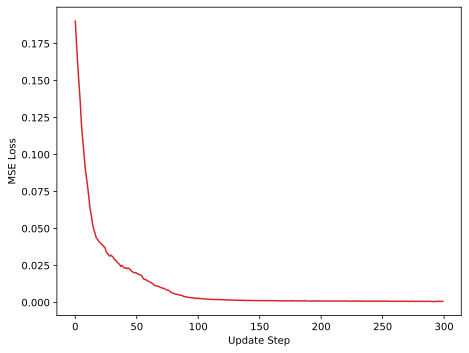

In [15]:
fig, ax = plt.subplots(1, 1, layout="constrained")
color = 'tab:red'
ax.set_xlabel('Update Step')
ax.set_ylabel('MSE Loss')
ax.plot(loss_history, color=color, label='Loss')

### RDF

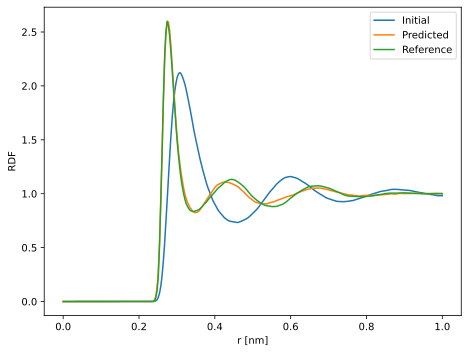

In [16]:
fig, ax = plt.subplots(1, 1, layout="constrained")
r = onp.linspace(0, 1, 300)
ax.plot(r, predicted_quantities[0]["rdf"], label='Initial')
ax.plot(r, predicted_quantities[num_updates]["rdf"], label='Predicted')
ax.plot(r, targets["rdf"]["target"], label='Reference')
ax.set_xlabel("r [nm]")
ax.set_ylabel("RDF")
ax.legend()

### ADF

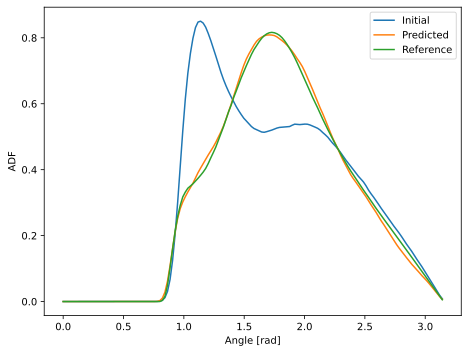

In [17]:
fig, ax = plt.subplots(1, 1, layout="constrained")
alpha = onp.linspace(0, onp.pi, 150)
ax.plot(alpha, predicted_quantities[0]["adf"], label='Initial')
ax.plot(alpha, predicted_quantities[num_updates]["adf"], label='Predicted')
ax.plot(alpha, targets["adf"]["target"], label='Reference')
ax.set_xlabel("Angle [rad]")
ax.set_ylabel("ADF")
ax.legend()

### Pressure

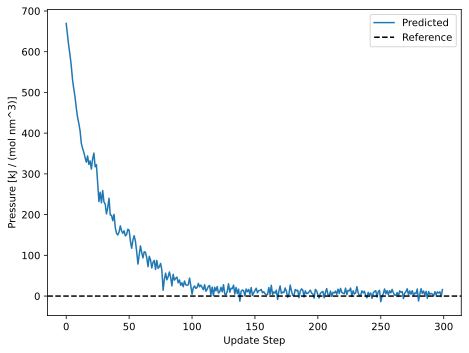

In [18]:
fig, ax = plt.subplots(1, 1, layout="constrained")
ax.set_xlabel('Update Step')
ax.set_ylabel('Pressure [kJ / (mol nm^3)]')
ax.plot([preds["pressure"] for preds in predicted_quantities.values()], label='Predicted')
ax.axhline(y=pressure_target, linestyle='--', label='Reference', color='k')
ax.legend()

## References

[^Thaler2021]: Thaler, S.; Zavadlav, J. Learning Neural Network Potentials from Experimental Data via Differentiable Trajectory Reweighting. _Nat Commun_ **2021**, _12_ (1), 6884. [https://doi.org/10.1038/s41467-021-27241-4](https://doi.org/10.1038/s41467-021-27241-4).

[^Reith2003]: Reith, D.; Pütz, M.; Müller-Plathe, F. Deriving Effective Mesoscale Potentials from Atomistic Simulations: Mesoscale Potentials from Atomistic Simulations. _J. Comput. Chem._ **2003**, _24_ (13), 1624–1636. [https://doi.org/10.1002/jcc.10307](https://doi.org/10.1002/jcc.10307).

[^Lyubartsev1995]: Lyubartsev, A. P.; Laaksonen, A. Calculation of Effective Interaction Potentials from Radial Distribution Functions: A Reverse Monte Carlo Approach. _Phys. Rev. E_ **1995**, _52_ (4), 3730–3737. [https://doi.org/10.1103/PhysRevE.52.3730](https://doi.org/10.1103/PhysRevE.52.3730).

[^Dhabal2014]: Dhabal, D.; Singh, M.; Wikfeldt, K. T.; Chakravarty, C. Triplet Correlation Functions in Liquid Water. _The Journal of Chemical Physics_ **2014**, _141_ (17), 174504. [https://doi.org/10.1063/1.4898755](https://doi.org/10.1063/1.4898755).

[^Torrie1977]: Torrie, G. M.; Valleau, J. P. Nonphysical Sampling Distributions in Monte Carlo Free-Energy Estimation: Umbrella Sampling. _Journal of Computational Physics_ **1977**, _23_ (2), 187–199. [https://doi.org/10.1016/0021-9991(77)90121-8](https://doi.org/10.1016/0021-9991(77)90121-8).

[^DimeNet]: Gasteiger, J.; Giri, S.; Margraf, J. T.; Günnemann, S. _Fast and Uncertainty-Aware Directional Message Passing for Non-Equilibrium Molecules_. [http://arxiv.org/abs/2011.14115](http://arxiv.org/abs/2011.14115) (accessed 2023-06-29).

[^Soper2008]: Soper, A. K.; Benmore, C. J. Quantum Differences between Heavy and Light Water. _Phys. Rev. Lett._ **2008**, _101_ (6), 065502. [https://doi.org/10.1103/PhysRevLett.101.065502](https://doi.org/10.1103/PhysRevLett.101.065502).